In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.engine import InputSpec
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten,Merge,  Input,Layer,merge
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.misc
from attention import SpatialTransformer
#from attention import SpatialTransformerLayer

Using Theano backend.
Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN not available)


In [2]:
batch_size = 8
nb_classes = 9
#image_size=(218,303)
#input_shape=(3,218,303)

#image_shape = (None, 128, 128, 1)
#images = Input(shape=image_shape[1:])

image_size=(128,128)
input_shape=(3,128,128)
classes=["chicken","ostrich",'bluebird','finch','frog','salemander','cobra','bird','flamingo']

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        '../data/train',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '../data/val',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical')

Found 10177 images belonging to 9 classes.
Found 1328 images belonging to 9 classes.


In [4]:
nb_epoch = 50
nb_filters=32
kernel_size=(3,3)
pool_size=(2,2)
input_shape=(3,128,128)
img = Input(shape=input_shape)

# initial weights for transformer
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((50, 6), dtype='float32')
weights = [W, b.flatten()]

In [5]:
modela = Sequential()
modela.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
modela.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
modela.add(Activation('relu'))
modela.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
modela.add(Activation('relu'))
modela.add(Flatten())
modela.add(Dense(50))
modela.add(Activation('relu'))
modela.add(Dense(6,weights=weights, name="transformation"))

modelb = Sequential()
modelb.add(SpatialTransformer(modela,input_shape=input_shape, name="transformed"))
modelb.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
modelb.add(Activation('relu'))
modelb.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
modelb.add(Activation('relu'))
modelb.add(Flatten())
modelb.add(Dense(9))
modelb.add(Activation('softmax'))

model = Model(input=img, output=modelb(img))

transformation_model = Model(input=modela.input,
                                 output=modela.get_layer("transformation").output)

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
model.summary()
model.fit_generator(train_generator,samples_per_epoch=1000, nb_epoch=nb_epoch)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 128, 128)   0                                            
____________________________________________________________________________________________________
sequential_2 (Sequential)        (None, 9)             10208941    input_1[0][0]                    
Total params: 10208941
____________________________________________________________________________________________________
Epoch 1/10
1000/1000 [==============================] - 46s - loss: 2.5910 - acc: 0.1130    
Epoch 2/10
1000/1000 [==============================] - 46s - loss: 2.1930 - acc: 0.1140    
Epoch 3/10
1000/1000 [==============================] - 46s - loss: 2.1919 - acc: 0.1310    
Epoch 4/10
1000/1000 [==============================] - 47s - loss: 2.2084 - acc: 0.1220    

In [7]:
score = model.evaluate_generator(test_generator, val_samples=10)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.28217297792
Test accuracy: 0.5625


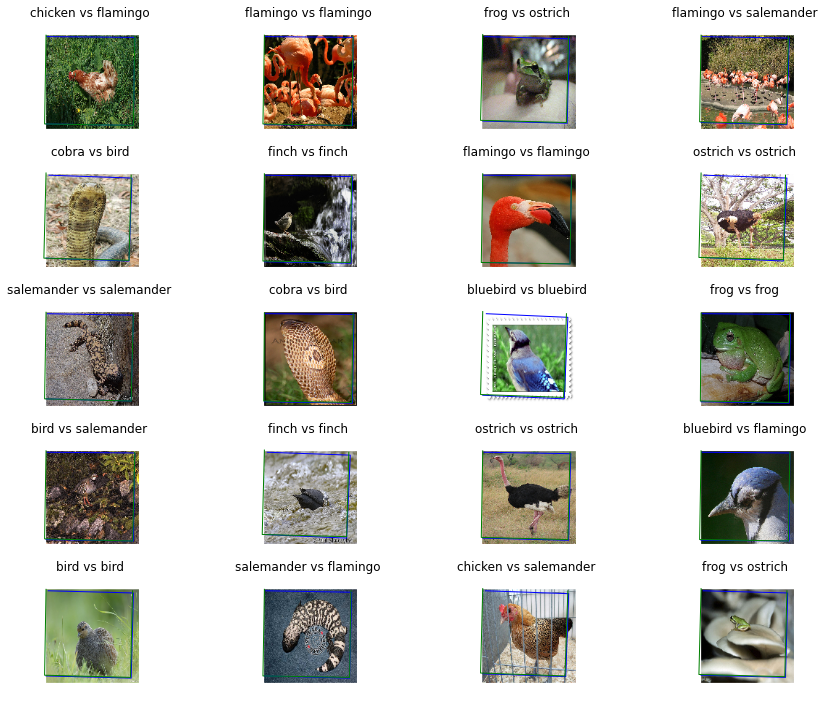

In [8]:
nx=4
ny=5
ith=0
fig = plt.figure(figsize=(3*ny, 3*nx))
for batch in test_generator:
    predicted=model.predict(batch[0])
    transformation = transformation_model.predict(batch[0])
    for (X,y,p,t) in zip(batch[0],batch[1],predicted,transformation):
        t=t.reshape((2,3))
        corners=np.array([[0,0,1],[X.shape[1],0,1],[X.shape[1],X.shape[2],1],[0,X.shape[2],1],[0,0,1]])
        pts=t.dot(corners.T).T.astype(np.int8)
        ax=fig.add_subplot(ny,nx,ith)
        img = scipy.misc.toimage(X*255,channel_axis=0)
        ax.set_title(classes[np.argmax(y)]+" vs "+classes[np.argmax(p)])
        ax.set_axis_off()
        ax.imshow(img)
        ax.plot(pts[0:-1],pts[1:])
        ith = ith + 1
        if (ith>=nx*ny):
            break
    if (ith>=nx*ny):
        break
plt.show()